### Imports, plot configuration

In [2]:
# ------------------------------------------------------------------------
# Library imports
# ------------------------------------------------------------------------

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
from matplotlib.lines import Line2D
from __future__ import annotations
from pathlib import Path
from typing import Any, Dict, Optional, Tuple

# ------------------------------------------------------------------------
# Global plotting configuration
# ------------------------------------------------------------------------
# set font size
mpl.rcParams.update({'font.size': 8})

# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

# Optional: make sure fonts are updated
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42

### Fetch data from nerd sqlite database

In [3]:
def fetch_fmod_run(
    db_path: str,
    temperature: int,
    selected_fmod_run_id: Optional[int] = None,
    sample_name: Optional[str] = None,
    treated_flag: Optional[int] = None,
    construct_family: Optional[str] = None,
) -> pd.DataFrame:
    """
    Retrieve `probe_fmod_run` rows with sequencing sample, reaction, and construct context.

    Parameters
    ----------
    db_path : str or path-like
        Path to the SQLite database file.
    temperature : int
        Reaction temperature (°C) used to filter probe reactions.
    selected_fmod_run_id : int, optional
        If provided, restrict results to a specific `probe_fmod_run.id`.
    sample_name : str, optional
        If provided, restrict results to a specific sequencing sample name.
    treated_flag : {0, 1}, optional
        If provided, restrict results to treated (1) or untreated (0)
        probe reactions.
    construct_family : str, optional
        If provided, restrict results to constructs belonging to this family
        (matches `meta_constructs.family`).

    Returns
    -------
    pandas.DataFrame
        DataFrame with one row per (fmod_run_id, reaction_time) combination and
        the following columns:

        - ``fmod_run_id`` : int
        - ``output_dir`` : str
        - ``sample_name`` : str
        - ``reaction_time`` : float
        - ``treated`` : int
        - ``construct.disp_name`` : str
    """
    conditions = [
        "pr.temperature = :temperature",
        "s.to_drop = 0",
    ]
    params: Dict[str, object] = {"temperature": temperature}

    if selected_fmod_run_id is not None:
        conditions.append("r.id = :fmod_run_id")
        params["fmod_run_id"] = selected_fmod_run_id

    if sample_name:
        conditions.append("s.sample_name = :sample_name")
        params["sample_name"] = sample_name

    if treated_flag is not None:
        conditions.append("pr.treated = :treated")
        params["treated"] = treated_flag

    if construct_family:
        conditions.append("mc.family = :construct_family")
        params["construct_family"] = construct_family

    where_clause = " AND ".join(conditions)

    query = f"""
        SELECT
            r.id AS fmod_run_id,
            r.output_dir,
            s.sample_name,
            pr.reaction_time,
            pr.treated,
            mc.disp_name AS "construct.disp_name"
        FROM probe_fmod_runs r
        JOIN sequencing_samples s ON s.id = r.s_id
        JOIN probe_reactions pr ON pr.s_id = s.id
        JOIN meta_constructs mc ON mc.id = pr.construct_id
        WHERE {where_clause}
        ORDER BY r.id, pr.reaction_time
    """

    with sqlite3.connect(db_path) as conn:
        df = pd.read_sql_query(query, conn, params=params)

    return df

#### Main functions

**parse_per_read_hist**

Finds and loads the per-read histogram for a given fmod run by searching the stored output directory and fallback pipeline/repo paths. Parses the histogram file (0,1,2,… mutations per read vs. frequency) and returns both the file locations checked and the loaded histogram table.

**attach_per_read_bin_frequencies**

Uses `parse_per_read_hist` to extract the frequencies of reads with 0, 1, and 2 mutations for each fmod run, and appends these frequencies as new columns (`0mut`, `1mut`, `2mut`) to the provided results DataFrame.

In [4]:
def parse_per_read_hist(
    run_row: pd.Series,
    db_path: str,
    selected_valtype: str,
) -> Dict[str, Any]:
    """
    Locate and parse per-read histogram files on disk for a given fmod run.

    Parameters
    ----------
    run_row : pandas.Series
        Single row from :func:`fetch_fmod_run`. Must contain the columns
        ``fmod_run_id``, ``output_dir``, and ``sample_name``.
    db_path : str or path-like
        Path to the SQLite database; used to infer pipeline and repository roots.
    selected_valtype : {"modrate", "modrateGA"}
        Which histogram type to treat as the primary one.

    Returns
    -------
    dict
        Dictionary with the following keys:

        - ``run`` : pandas.Series
            The input row.
        - ``hist_files`` : dict[str, pathlib.Path]
            Mapping from histogram filename to discovered path.
        - ``checked`` : list[pathlib.Path]
            All paths that were checked for histogram files.
        - ``histogram`` : pandas.DataFrame or None
            Parsed per-read histogram; ``None`` if not found or failed to parse.
        - ``x_label`` : str
            X-axis label corresponding to ``selected_valtype``.

    Raises
    ------
    ValueError
        If ``selected_valtype`` is not one of ``{"modrate", "modrateGA"}``.
    """
    hist_meta = {
        "modrate": ("per_read_histogram.txt", "Mutations per read"),
        "modrateGA": ("per_read_histogram.txtga", "GA mismatches per read"),
    }
    if selected_valtype not in hist_meta:
        raise ValueError(
            "`selected_valtype` must be either 'modrate' or 'modrateGA' for per-read histograms."
        )

    hist_filename, x_label = hist_meta[selected_valtype]

    sample_name = run_row["sample_name"]
    raw_output_dir = run_row["output_dir"]
    fmod_run_id = run_row["fmod_run_id"]

    print(f"Run {fmod_run_id} (sample: {sample_name})")
    print(f"Stored output_dir: {raw_output_dir}")

    output_path = Path(raw_output_dir).expanduser()
    pipeline_root = Path(db_path).resolve().parent if db_path is not None else Path.cwd()
    repo_root = pipeline_root.parent

    def _candidate_dirs():
        """Yield candidate directories to search for histogram files."""
        seen = set()

        def _emit(path: Path):
            key = str(path)
            if key not in seen:
                seen.add(key)
                yield path

        # 1) The stored directory itself
        for item in _emit(output_path):
            yield item

        # 2) Variants under pipeline_root / repo_root if "mut_count" appears in the path
        parts = output_path.parts
        if "mut_count" in parts:
            last_idx = max(i for i, part in enumerate(parts) if part == "mut_count")
            suffix = Path(*parts[last_idx:])
            for base in (
                pipeline_root,
                pipeline_root / "04_run_mutcounts",
                repo_root,
                repo_root / "examples",
            ):
                candidate = base / suffix
                for item in _emit(candidate):
                    yield item

    checked = []
    found: Dict[str, Path] = {}

    for dir_candidate in _candidate_dirs():
        for filename in ("per_read_histogram.txt", "per_read_histogram.txtga"):
            hist_path = dir_candidate / filename
            checked.append(hist_path)
            if hist_path.exists():
                found[filename] = hist_path

    if found:
        for name, path in found.items():
            print(f"✓ Found {name} at {path}")
    else:
        print("No histogram files found. Checked the following paths:")
        for path in checked:
            print(f" - {path}")

    hist_path = found.get(hist_filename)
    hist_df: Optional[pd.DataFrame] = None
    if hist_path is not None:
        try:
            hist_df = pd.read_csv(hist_path, sep="\t").sort_values("bin_left")
        except Exception as exc:  # noqa: BLE001
            print(f"Failed to read {hist_path}: {exc}")

    return {
        "run": run_row,
        "hist_files": found,
        "checked": checked,
        "histogram": hist_df,
        "x_label": x_label,
    }

def attach_per_read_bin_frequencies(
    db_path: str,
    result_df: pd.DataFrame,
    selected_valtype: str = "modrate",
) -> pd.DataFrame:
    """
    Annotate each fmod run with 0/1/2-mutation bin frequencies from per-read histograms.

    For every row in ``result_df``, this function locates the corresponding per-read
    histogram (via :func:`parse_per_read_hist`) and attaches the frequencies of
    reads with 0, 1, or 2 mutations.

    Parameters
    ----------
    db_path : str or path-like
        Path to the SQLite database file. Used by :func:`parse_per_read_hist` to
        infer pipeline and repository roots.
    result_df : pandas.DataFrame
        DataFrame containing one row per fmod run. Must include at least the
        columns ``fmod_run_id``, ``output_dir``, ``sample_name``, and
        ``reaction_time``.
    selected_valtype : {"modrate", "modrateGA"}, optional
        Histogram type to use. ``"modrate"`` corresponds to
        ``per_read_histogram.txt``, while ``"modrateGA"`` corresponds to
        ``per_read_histogram.txtga``. Default is ``"modrate"``.

    Returns
    -------
    pandas.DataFrame
        Copy of ``result_df`` with three additional columns:

        - ``0mut`` : float
        - ``1mut`` : float
        - ``2mut`` : float

        representing the frequency of reads with 0, 1, and 2 mutations,
        respectively. If a histogram is missing, values remain ``NaN``.
    """
    bins = [0, 1, 2]
    annotated = result_df.copy()
    for b in bins:
        annotated[f"{b}mut"] = np.nan

    for idx, row in annotated.iterrows():
        lookup = parse_per_read_hist(row, db_path, selected_valtype)
        hist_df = (lookup or {}).get("histogram")
        if hist_df is None:
            continue

        freq_map = dict(zip(hist_df["bin_left"].astype(int), hist_df["frequency"]))
        for b in bins:
            annotated.at[idx, f"{b}mut"] = float(freq_map.get(b, 0.0))

    return annotated

#### Plotting functions

In [19]:
def plot_histogram(
    hist_df: Optional[pd.DataFrame],
    selected_fmod_run_id: int,
    x_label: str,
    figsize: Tuple[float, float] = (6, 3),
):
    """
    Plot a per-read histogram DataFrame.

    Parameters
    ----------
    hist_df : pandas.DataFrame or None
        Histogram data. Must contain columns ``bin_left`` and ``frequency``.
        If ``None`` or empty, no plot is produced.
    selected_fmod_run_id : int
        Identifier of the fmod run; used in the plot title.
    x_label : str
        X-axis label (depends on ``selected_valtype``).
    figsize : tuple of float, optional
        Figure size in inches, by default ``(6, 3)``.

    Returns
    -------
    fig : matplotlib.figure.Figure or None
        Created figure, or ``None`` if nothing was plotted.
    ax : matplotlib.axes.Axes or None
        Created axes, or ``None`` if nothing was plotted.
    """
    if hist_df is None or hist_df.empty:
        print("No histogram data to plot.")
        return None, None

    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(hist_df["bin_left"], hist_df["frequency"], width=0.9, alpha=0.7)
    ax.set_xlabel(x_label)
    ax.set_ylabel("Frequency")
    ax.set_title(f"Per-read histogram – run {selected_fmod_run_id}")
    ax.set_xticks(hist_df["bin_left"].astype(int))
    ax.set_ylim(0, hist_df["frequency"].max() * 1.05)
    ax.margins(x=0)
    plt.tight_layout()

    return fig, ax

def plot_muts_frequency(
    result_df: pd.DataFrame,
    out_name: str,
):
    """
    Plot frequencies of reads with 0, 1, and 2 mutations as a function of reaction time.

    Parameters
    ----------
    result_df : pandas.DataFrame
        DataFrame returned by :func:`attach_per_read_bin_frequencies`. Must contain
        the columns ``reaction_time``, ``0mut``, ``1mut``, and ``2mut``.
    out_name : str
        Basename used for saving the PDF figure as
        ``"mutation_freq_{out_name}.pdf"``.

    Returns
    -------
    fig : matplotlib.figure.Figure
        Created figure.
    ax : matplotlib.axes.Axes
        Created axes.
    """
    fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    sns.scatterplot(
        data=result_df,
        x="reaction_time",
        y="0mut",
        color="#66c2a5",
        ax=ax,
        label="0 muts per read"
    )
    sns.scatterplot(
        data=result_df,
        x="reaction_time",
        y="1mut",
        color="#fc8d62",
        ax=ax,
        label="1 mut per read",
    )
    sns.scatterplot(
        data=result_df,
        x="reaction_time",
        y="2mut",
        color="#8da0cb",
        ax=ax,
        label="2 muts per read",
    )
    # print max of 2 muts per read
    ratio_2muts = result_df["2mut"].mean() / result_df["1mut"].mean()
    print(f"Ratio 2:1 muts per read: {ratio_2muts:.4f}")

    ax.set_ylabel("Frequency")
    ax.set_xlabel("Reaction Time (s)")

    plt.tight_layout()
    plt.savefig(f"mutation_freq_{out_name}.pdf")
    plt.show()

    return fig, ax

### Execution of functions (run cells below)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


Run 155 (sample: 049-EKC-WT-25c-b-1-p)
Stored output_dir: /gpfs/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.065.refactoring_data_analysis/nerd/examples/all_mutcounts/mut_count/mut_count___cfg-f29c3bd/artifacts/049-EKC-WT-25c-b-1-p
✓ Found per_read_histogram.txt at /Volumes/MiniVault/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.07.nerd/Choi_PRIME_Chemprobing_2026/Core_nerd_analysis/04_run_mutcounts/mut_count/mut_count___cfg-f29c3bd/artifacts/049-EKC-WT-25c-b-1-p/per_read_histogram.txt
✓ Found per_read_histogram.txtga at /Volumes/MiniVault/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.07.nerd/Choi_PRIME_Chemprobing_2026/Core_nerd_analysis/04_run_mutcounts/mut_count/mut_count___cfg-f29c3bd/artifacts/049-EKC-WT-25c-b-1-p/per_read_histogram.txtga
Run 156 (sample: 050-EKC-WT-25c-b-2-p)
Stored output_dir: /gpfs/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.065.refactoring_data_analysis/nerd/examples/all_mutco

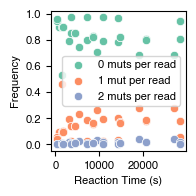

(<Figure size 200x200 with 1 Axes>,
 <Axes: xlabel='Reaction Time (s)', ylabel='Frequency'>)

In [20]:
NERD_SQLITE = '../../Core_nerd_analysis/nerd.sqlite'

# 25°C
fmod_runs = fetch_fmod_run(NERD_SQLITE, temperature = 25, construct_family = 'Salm_4U_thermometer')
fmod_runs = fmod_runs[fmod_runs['construct.disp_name'] == '4U_wt']
result_df = attach_per_read_bin_frequencies(NERD_SQLITE, fmod_runs, selected_valtype="modrate")
plot_muts_frequency(result_df, '25C_4Uwt')

Run 265 (sample: 001_fourU_WT_18c_a_1_p)
Stored output_dir: /gpfs/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.065.refactoring_data_analysis/nerd/examples/all_mutcounts/mut_count/mut_count___cfg-453b76a/artifacts/001_fourU_WT_18c_a_1_p
✓ Found per_read_histogram.txt at /Volumes/MiniVault/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.07.nerd/Choi_PRIME_Chemprobing_2026/Core_nerd_analysis/04_run_mutcounts/mut_count/mut_count___cfg-453b76a/artifacts/001_fourU_WT_18c_a_1_p/per_read_histogram.txt
✓ Found per_read_histogram.txtga at /Volumes/MiniVault/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.07.nerd/Choi_PRIME_Chemprobing_2026/Core_nerd_analysis/04_run_mutcounts/mut_count/mut_count___cfg-453b76a/artifacts/001_fourU_WT_18c_a_1_p/per_read_histogram.txtga
Run 266 (sample: 002_fourU_WT_18c_a_2_p)
Stored output_dir: /gpfs/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.065.refactoring_data_analysis/nerd/examples

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


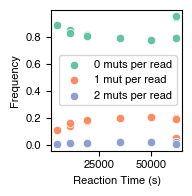

(<Figure size 200x200 with 1 Axes>,
 <Axes: xlabel='Reaction Time (s)', ylabel='Frequency'>)

In [21]:
# 18°C
fmod_runs = fetch_fmod_run(NERD_SQLITE, temperature = 18, construct_family = 'Salm_4U_thermometer')
fmod_runs = fmod_runs[fmod_runs['construct.disp_name'] == '4U_wt']
result_df = attach_per_read_bin_frequencies(NERD_SQLITE, fmod_runs, selected_valtype="modrate")
plot_muts_frequency(result_df, '18C_4Uwt')

Run 300 (sample: 067-EKC-WT-37c-b-1-p)
Stored output_dir: /gpfs/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.065.refactoring_data_analysis/nerd/examples/all_mutcounts/mut_count/mut_count___cfg-dc0ea4b/artifacts/067-EKC-WT-37c-b-1-p
✓ Found per_read_histogram.txt at /Volumes/MiniVault/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.07.nerd/Choi_PRIME_Chemprobing_2026/Core_nerd_analysis/04_run_mutcounts/mut_count/mut_count___cfg-dc0ea4b/artifacts/067-EKC-WT-37c-b-1-p/per_read_histogram.txt
✓ Found per_read_histogram.txtga at /Volumes/MiniVault/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.07.nerd/Choi_PRIME_Chemprobing_2026/Core_nerd_analysis/04_run_mutcounts/mut_count/mut_count___cfg-dc0ea4b/artifacts/067-EKC-WT-37c-b-1-p/per_read_histogram.txtga
Run 301 (sample: 068-EKC-WT-37c-b-2-p)
Stored output_dir: /gpfs/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.065.refactoring_data_analysis/nerd/examples/all_mutco

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


Ratio 2:1 muts per read: 0.1772


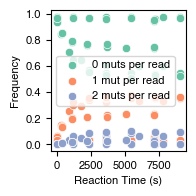

(<Figure size 200x200 with 1 Axes>,
 <Axes: xlabel='Reaction Time (s)', ylabel='Frequency'>)

In [22]:
# 37°C
fmod_runs = fetch_fmod_run(NERD_SQLITE, temperature = 37, construct_family = 'Salm_4U_thermometer')
fmod_runs = fmod_runs[fmod_runs['construct.disp_name'] == '4U_wt']
result_df = attach_per_read_bin_frequencies(NERD_SQLITE, fmod_runs, selected_valtype="modrate")
plot_muts_frequency(result_df, '37C_4Uwt')

Run 422 (sample: 073-EKC-WT-45c-b-1-p)
Stored output_dir: /gpfs/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.065.refactoring_data_analysis/nerd/examples/all_mutcounts/mut_count/mut_count___cfg-e3b7ba4/artifacts/073-EKC-WT-45c-b-1-p
✓ Found per_read_histogram.txt at /Volumes/MiniVault/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.07.nerd/Choi_PRIME_Chemprobing_2026/Core_nerd_analysis/04_run_mutcounts/mut_count/mut_count___cfg-e3b7ba4/artifacts/073-EKC-WT-45c-b-1-p/per_read_histogram.txt
✓ Found per_read_histogram.txtga at /Volumes/MiniVault/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.07.nerd/Choi_PRIME_Chemprobing_2026/Core_nerd_analysis/04_run_mutcounts/mut_count/mut_count___cfg-e3b7ba4/artifacts/073-EKC-WT-45c-b-1-p/per_read_histogram.txtga
Run 423 (sample: 074-EKC-WT-45c-b-2-p)
Stored output_dir: /gpfs/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.065.refactoring_data_analysis/nerd/examples/all_mutco

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


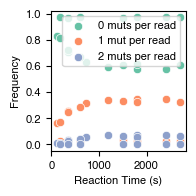

(<Figure size 200x200 with 1 Axes>,
 <Axes: xlabel='Reaction Time (s)', ylabel='Frequency'>)

In [23]:
# 45°C
fmod_runs = fetch_fmod_run(NERD_SQLITE, temperature = 45, construct_family = 'Salm_4U_thermometer')
fmod_runs = fmod_runs[fmod_runs['construct.disp_name'] == '4U_wt']
result_df = attach_per_read_bin_frequencies(NERD_SQLITE, fmod_runs, selected_valtype="modrate")
plot_muts_frequency(result_df, '45C_4Uwt')

Run 601 (sample: 007-fourU-WT-65c-b-1-p)
Stored output_dir: /gpfs/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.065.refactoring_data_analysis/nerd/examples/all_mutcounts/mut_count/mut_count___cfg-34a5274/artifacts/007-fourU-WT-65c-b-1-p
✓ Found per_read_histogram.txt at /Volumes/MiniVault/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.07.nerd/Choi_PRIME_Chemprobing_2026/Core_nerd_analysis/04_run_mutcounts/mut_count/mut_count___cfg-34a5274/artifacts/007-fourU-WT-65c-b-1-p/per_read_histogram.txt
✓ Found per_read_histogram.txtga at /Volumes/MiniVault/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.07.nerd/Choi_PRIME_Chemprobing_2026/Core_nerd_analysis/04_run_mutcounts/mut_count/mut_count___cfg-34a5274/artifacts/007-fourU-WT-65c-b-1-p/per_read_histogram.txtga
Run 602 (sample: 008-fourU-WT-65c-b-2-p)
Stored output_dir: /gpfs/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.065.refactoring_data_analysis/nerd/examples

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


Ratio 2:1 muts per read: 0.1140


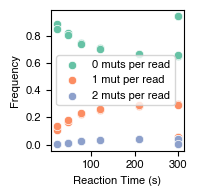

(<Figure size 200x200 with 1 Axes>,
 <Axes: xlabel='Reaction Time (s)', ylabel='Frequency'>)

In [24]:
# 65°C
fmod_runs = fetch_fmod_run(NERD_SQLITE, temperature = 65, construct_family = 'Salm_4U_thermometer')
fmod_runs = fmod_runs[fmod_runs['construct.disp_name'] == '4U_wt']
result_df = attach_per_read_bin_frequencies(NERD_SQLITE, fmod_runs, selected_valtype="modrate")
plot_muts_frequency(result_df, '65C_4Uwt')

Run 764 (sample: RRRY_001-EKC-fourUnew-WT-70C-dms-MaP-1)
Stored output_dir: /gpfs/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.065.refactoring_data_analysis/nerd/examples/all_mutcounts/mut_count/mut_count___cfg-2316bc5/artifacts/RRRY_001-EKC-fourUnew-WT-70C-dms-MaP-1
✓ Found per_read_histogram.txt at /Volumes/MiniVault/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.07.nerd/Choi_PRIME_Chemprobing_2026/Core_nerd_analysis/04_run_mutcounts/mut_count/mut_count___cfg-2316bc5/artifacts/RRRY_001-EKC-fourUnew-WT-70C-dms-MaP-1/per_read_histogram.txt
✓ Found per_read_histogram.txtga at /Volumes/MiniVault/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.07.nerd/Choi_PRIME_Chemprobing_2026/Core_nerd_analysis/04_run_mutcounts/mut_count/mut_count___cfg-2316bc5/artifacts/RRRY_001-EKC-fourUnew-WT-70C-dms-MaP-1/per_read_histogram.txtga
Run 765 (sample: YYYR_001-EKC-fourUnew-WT-70C-dms-MaP-1)
Stored output_dir: /gpfs/projects/b1044/Computational_Output/EKC

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


Run 807 (sample: 013-fourU-WT-70c-a-1-p)
Stored output_dir: /gpfs/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.065.refactoring_data_analysis/nerd/examples/all_mutcounts/mut_count/mut_count___cfg-740fa40/artifacts/013-fourU-WT-70c-a-1-p
✓ Found per_read_histogram.txt at /Volumes/MiniVault/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.07.nerd/Choi_PRIME_Chemprobing_2026/Core_nerd_analysis/04_run_mutcounts/mut_count/mut_count___cfg-740fa40/artifacts/013-fourU-WT-70c-a-1-p/per_read_histogram.txt
✓ Found per_read_histogram.txtga at /Volumes/MiniVault/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.07.nerd/Choi_PRIME_Chemprobing_2026/Core_nerd_analysis/04_run_mutcounts/mut_count/mut_count___cfg-740fa40/artifacts/013-fourU-WT-70c-a-1-p/per_read_histogram.txtga
Run 810 (sample: 014-fourU-WT-70c-a-2-p)
Stored output_dir: /gpfs/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.065.refactoring_data_analysis/nerd/examples

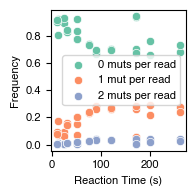

(<Figure size 200x200 with 1 Axes>,
 <Axes: xlabel='Reaction Time (s)', ylabel='Frequency'>)

In [25]:
# 70°C
fmod_runs = fetch_fmod_run(NERD_SQLITE, temperature = 70, construct_family = 'Salm_4U_thermometer')
fmod_runs = fmod_runs[fmod_runs['construct.disp_name'] == '4U_wt']
result_df = attach_per_read_bin_frequencies(NERD_SQLITE, fmod_runs, selected_valtype="modrate")
plot_muts_frequency(result_df, '70C_4Uwt')